In [7]:
from pathlib import Path
import os
import numpy as np
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


In [8]:
noise_class=3

In [9]:
TRAIN_INPUT_DIR = Path('Datasets/US_Class'+str(noise_class)+'_Train_Input')
TRAIN_TARGET_DIR = Path('Datasets/US_Class'+str(noise_class)+'_Train_Output')
TEST_NOISY_DIR = Path('Datasets/US_Class'+str(noise_class)+'_Test_Input')
TEST_CLEAN_DIR = Path('Datasets/clean_testset_wav')

In [10]:
SAMPLE_RATE = 48000
N_FFT = (SAMPLE_RATE * 64) // 1000 
HOP_LENGTH = (SAMPLE_RATE * 16) // 1000 

In [11]:
class SpeechDataset(Dataset):
    
    def __init__(self, noisy_files, target_files, n_fft=64, hop_length=16):
        super().__init__()
        
        self.noisy_files = sorted(noisy_files)
        self.target_files = sorted(target_files)
        
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.len_ = len(self.noisy_files)
        
        self.max_len = 150000
     
    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        waveform, _ = torchaudio.load(file)
        print(_)
        return waveform
  
    def __getitem__(self, index):

        file_t=self.target_files[index]
        file_n=self.noisy_files[index]
        file_t=str(file_t)
        file_n=str(file_n)
        x_target = self.load_sample(file_t)
        x_noisy = self.load_sample(file_n)
        
        x_target = self.prepare_sample(x_target)
        x_noisy = self.prepare_sample(x_noisy)
        
        x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True,return_complex=True)
        x_target_stft = torch.stft(input=x_target, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True,return_complex=True)
        # return 0
        return x_noisy_stft, x_target_stft
        
    def prepare_sample(self, waveform):
        waveform = waveform.numpy()
        # print(waveform.shape)
        current_len = waveform.shape[1]
        # print(current_len)
        output = np.zeros((1, self.max_len), dtype='float32')
        # print(output.shape)
        output[0, -current_len:] = waveform[0,:self.max_len]
        output = torch.from_numpy(output)
        # print(output.shape)
        return output

In [12]:
train_input_files = sorted(list(TRAIN_INPUT_DIR.rglob('*.wav')))
train_target_files = sorted(list(TRAIN_TARGET_DIR.rglob('*.wav')))

test_noisy_files = sorted(list(TEST_NOISY_DIR.rglob('*.wav')))
test_clean_files = sorted(list(TEST_CLEAN_DIR.rglob('*.wav')))

# print("No. of Training files:",len(train_input_files))
# print("No. of Testing files:",len(test_noisy_files))

In [13]:
test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)
train_dataset = SpeechDataset(train_input_files, train_target_files, N_FFT, HOP_LENGTH)

In [14]:
import matplotlib.pyplot as plt
import librosa

In [15]:
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    win_length=16,
    hop_length=HOP_LENGTH,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

In [16]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


In [17]:
spec=spectrogram(train_dataset.load_sample("Datasets/US_Class3_Test_Input/p232_001.wav"))

96000


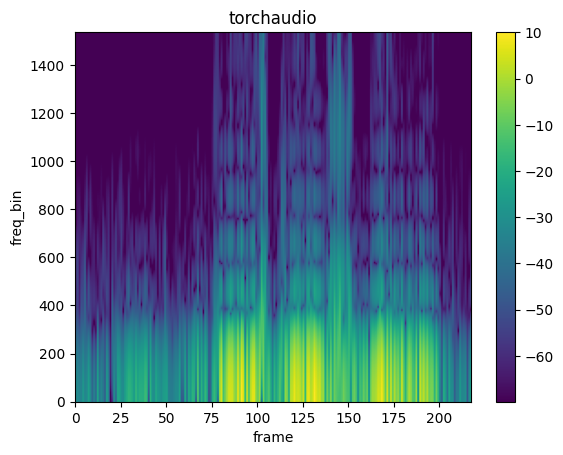

In [18]:
plot_spectrogram(spec[1], title="torchaudio")

In [19]:
file1,file2=train_dataset.__getitem__(0)
file1.shape

48000
48000


c:\Users\Avnesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:660: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at ..\aten\src\ATen\native\SpectralOps.cpp:843.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


torch.Size([1, 1537, 196])

In [20]:
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=True)
train_loader=DataLoader(train_dataset,batch_size=2,shuffle=True)

In [21]:
class CConv2d(nn.Module):

    def __init__(self,in_channels,out_channels,kernel_size,stride=1,padding=0):
        super().__init__()

        self.in_channels=in_channels
        self.out_channels=out_channels
        self.kernel.size=kernel_size
        self.padding=padding
        self.stride=stride

        self.real_conv= nn.Conv2d(in_channels=self.in_channels,
                                  out_channels=self.out_channels,
                                  kernel_size=self.kernel_size,
                                  padding=self.padding,
                                  stride=self.stride)
        self.imag_conv = nn.Conv2d(in_channels=self.in_channels,
                                  out_channels=self.out_channels,
                                  kernel_size=self.kernel_size,
                                  padding=self.padding,
                                  stride=self.stride)
        
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.imag_conv.weight)
    def forward(self,x):
        x_real = x[...,0]
        x_imag= x[...,1]

        c_real = self.real_conv(x_real)-self.imag_conv(x_imag)
        c_imag=self.imag_conv(x_real)+self.real_conv(x_imag)

        output = torch.stack([c_real,c_imag],dim=-1)
        return output


In [22]:
class CConvTranspose2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,out_padding=0,padding=0):
        super().__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.kernel_size=kernel_size
        self.padding=padding
        self.out_padding=out_padding
        self.stride=stride

        self.real_convt= nn.ConvTranspose2d(in_channels=self.in_channels,
                                            out_channels=self.out_channels,
                                            kernel_size=self.kernel_size,
                                            out_padding=self.out_padding,
                                            stride=self.stride,
                                            padding=self.padding)
        self.imag_convt=nn.ConvTranspose2d(in_channels=self.in_channels,
                                            out_channels=self.out_channels,
                                            kernel_size=self.kernel_size,
                                            out_padding=self.out_padding,
                                            stride=self.stride,
                                            padding=self.padding)
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.imag_convt.weight)


    def forward(self,x):
            
        x_real=x[...,0]
        x_imag=x[...,1]

        c_real=self.real_convt(x_real)-self.imag_convt(x_imag)
        c_imag=self.imag_convt(x_real)+self.real_convt(x_imag)
            
        output=torch.stack([c_real,c_imag],dim=-1)

        return output

In [23]:
class CBatchNorm2D(nn.Module):
    def __init__(self,num_feature,eps=1e-05,momentum=0.1,affine=True, track_running_stats=True):
        super().__init__()
        self.num_features=num_feature
        self.affine=affine
        self.momentum=momentum
        self.eps=eps
        self.track_running_stats=track_running_stats

        self.real_b=nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.imag_b=nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        
    def forward(self,x):
        real=x[...,0]
        imag=x[...,1]

        real_cb=self.real_b(real)
        imag_cb=self.imag_b(imag)

        output=torch.stack([real_cb,imag_cb],dim=-1)
        return output
    

In [24]:
class Encoder(nn.Module):
    def __init__(self,in_channels=1,out_channels=45,stride=(2,2),kernel_size=(7,5),padding=(0,0)):
        super().__init__()
        self.kernel_size=kernel_size
        self.stride=stride
        self.padding=padding
        self.in_channels=in_channels
        self.out_channels=out_channels

        self.cconv= CConv2d(in_channels=self.in_channels,
                            out_channels=self.out_channels,
                            kernel_size=self.kernel_size,
                            stride=self.stride,
                            padding=self.padding)
        self.cbn=CBatchNorm2D(num_feature=self.out_channels)

        self.leaky_relu=nn.LeakyReLU()
    def forward(self,x):

        conved=self.cconv(x)

        normed=self.cbn(conved)
        acted=self.leaky_relu(normed)
        return acted


In [25]:
class Decoder(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,padding,output_padding,last_layer):
        super().__init__()

        self.filter_size = kernel_size
        self.stride_size = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_padding = output_padding
        self.padding = padding
        
        self.last_layer = last_layer
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, output_padding=self.output_padding, padding=self.padding)
        
        self.cbn = CBatchNorm2D(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output

In [26]:
class DCUnet(nn.Module):


    def __init__(self,n_fft=64,hop_length=16):

        super().__init__()
        self.hop_length=hop_length
        self.n_fft=n_fft

        self.set_param(model_complexity=45,model_depth=20,input_channels=1)

        self.model_length=20//2
        self.encoders=[]

        for i in range(self.model_length):

            module=Encoder(in_channels=self.enc_channels[i],
                           out_channels=self.enc_channels[i+1],
                           stride=self.enc_strides[i],
                           kernel_size=self.enc_kernel_sizes[i],
                           padding=self.enc_paddings[i])
            self.add_module("encoder{}".format(i), module)
            self.encoders.append(module)

        self.decoders=[]

        for i in range(self.model_length):
            if i!=self.model_length-1:
                module = Decoder(in_channels=self.enc_channels[self.model_length-i]+self.dec_channels[i],
                              out_channels=self.dec_channels[i+1],
                              padding=self.dec_paddings[i],
                              output_padding=self.dec_output_padding[i],
                              stride=self.dec_strides[i],
                              kernel_size=self.dec_kernel_sizes[i])
            else:
                module=Decoder(in_channels=self.enc_channels[self.model_length-i]+self.dec_channels[i],
                              out_channels=self.dec_channels[i+1],
                              padding=self.dec_paddings[i],
                              output_padding=self.dec_output_padding[i],
                              stride=self.dec_strides[i],
                              kernel_size=self.dec_kernel_sizes[i],
                              last_layer=True)
            self.add_module("decoder{}".format(i), module)
            self.decoders.append(module)




    def set_param(self,model_complexity,model_depth=20,input_channels=1):
        if model_depth==20:

            self.enc_channels = [input_channels,
                                 model_complexity,
                                 model_complexity,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 128]
            
            self.dec_channels = [0,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity,
                                 model_complexity,
                                 1]
            
            self.enc_kernel_sizes = [(7, 1),
                                     (1, 7),
                                     (7, 5),
                                     (7, 5),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3)]
            
            self.enc_paddings = [(3, 0),
                                 (0, 3),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0)]
            
            self.dec_kernel_sizes = [(7, 1),
                                     (1, 7),
                                     (7, 5),
                                     (7, 5),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3)]
            
            self.enc_strides = [(1, 1),
                                (1, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1)]
            
            self.dec_strides = [(1, 1),
                                (1, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1)]
            
            self.dec_paddings = [(0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 3),
                                 (3, 0)]
            
            self.dec_output_padding = [(0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0)]
            
        else:
            raise ValueError("Unknown model depth : {}".format(model_depth))
    def forward(self,x,is_istft=True):

        orig_x=x
        xs=[]
        
        for i,encoder in enumerate(self.encoders):

            xs.append(x)
            x=encoder(x)

        p=x

        for i, decoder in enumerate(self.decoders):

            p=decoder(p)

            if i == self.model_length-1:
                break
            p=torch.cat([p,xs[self.model_length-i-1]],dim=1)
        
        mask=p

        output = mask *orig_x

        output = torch.squeeze(output,1)

        if is_istft: 
            output=torch.istft(output,n_fft=self.n_fft,hop_length=self.hop_length,normalized=True)
        return output  


       
